# Testing for the low risk anomaly with 5x5 size-volatility portfolios

Following the methodology in the paper, to test whether the low risk effect is restricted to large cap stocks, we analyze 5x5 size-volatility portfolios to see if the low-risk effect holds across different portfolios sorted by market capitalization, first, when split into equal groups based on size (market cap), and then when split based on the Fama-French size breakpoints (3rd, 7th, 13th and 25th percentiles of market cap)

# Import packages and load data

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Load data
market_cap_mapping_path = 'clean data/quarterly market cap mapping.xlsx'
momentum_path = 'clean data/quarterly momentum.xlsx'
net_payout_yield_path = 'clean data/quarterly net payout yield.xlsx'
price_path = 'clean data/quarterly price.xlsx'
volatility_path = 'clean data/quarterly volatility.xlsx'

mcap_map = pd.read_excel(market_cap_mapping_path)
momentum = pd.read_excel(momentum_path)
npy = pd.read_excel(net_payout_yield_path)
price = pd.read_excel(price_path)
volatility = pd.read_excel(volatility_path)
outstanding_shares = pd.read_excel('clean data/quarterly outstanding shares.xlsx')

price.set_index('quarter', inplace=True)
momentum.set_index('quarter', inplace=True)
npy.set_index('quarter', inplace=True)
volatility.set_index('quarter', inplace=True)
outstanding_shares.set_index('quarter',inplace = True)

mcap_map.set_index('quarter',inplace = True)
mcapmap = mcap_map
mcapmap = pd.DataFrame(mcap_map.apply(lambda row: row.dropna().tolist(), axis=1))
mcapmap.columns = mcapmap.columns.map(str)
mcapmap.rename(columns={'0': 'top1100'}, inplace=True)

mcap = pd.read_excel('clean data/quarterly market cap.xlsx')
mcap.set_index('quarter',inplace = True)


# 5x5 size-volatility portfolio analysis with equal size buckets

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DataFrame to store returns for 5x5 Size-Volatility portfolios
size_vol_returns_df = pd.DataFrame(
    index=mcap.index, 
    columns=[f"Size_{i+1}-Vol_{j+1}" for i in range(5) for j in range(5)]
)
  
for quarter in mcap.index:
    # Extract the pool of stocks for the quarter from mcapmap
    pool_of_stocks = set(mcapmap.loc[quarter].dropna().explode())
    
    mcap_quarter = pd.to_numeric(mcap.loc[quarter], errors='coerce')
    
    # Filter valid stocks 
    valid_stocks = pool_of_stocks.intersection(mcap_quarter.dropna().index).intersection(
        volatility.loc[quarter].dropna().index)

    # get subsets of market cap and volatility data for valid stocks
    mcap_data = mcap_quarter.loc[valid_stocks]
    vol_data = volatility.loc[quarter, valid_stocks]

    # Sort stocks into 5 equal-sized size groups based on market cap
    sorted_stocks = mcap_data.sort_values().index.tolist()
    size_groups = {
        f"Size_{i+1}": sorted_stocks[i * len(sorted_stocks) // 5:(i + 1) * len(sorted_stocks) // 5]
        for i in range(5)
    }

    for size_group, size_stocks in size_groups.items():
        # Filter volatility data for stocks in the size group
        vol_subset = vol_data.loc[size_stocks].dropna()

        # Sort stocks into 5 equal-sized volatility groups within each size group
        vol_sorted_stocks = vol_subset.sort_values().index.tolist()
        vol_size = len(vol_sorted_stocks) // 5
        vol_groups = {
            f"{size_group}-Vol_{j+1}": vol_sorted_stocks[j * vol_size:(j + 1) * vol_size]
            for j in range(5)
        }

        # Calculate returns for each size-volatility portfolio
        if quarter != mcap.index[-1]:  
            next_quarter = mcap.index[mcap.index.get_loc(quarter) + 1]

            for vol_group, portfolio in vol_groups.items():
                if len(portfolio) > 0:
                    portfolio_return = calculate_ew_returns(
                        portfolio, price.loc[quarter], price.loc[next_quarter]
                    )
                    size_vol_returns_df.loc[quarter, vol_group] = portfolio_return
                else:
                    size_vol_returns_df.loc[quarter, vol_group] = 0

size_vol_returns_df = size_vol_returns_df.astype(float)

size_vol_returns_df

,Size_1-Vol_1,Size_1-Vol_2,Size_1-Vol_3,Size_1-Vol_4,Size_1-Vol_5,Size_2-Vol_1,Size_2-Vol_2,Size_2-Vol_3,Size_2-Vol_4,Size_2-Vol_5,...,Size_4-Vol_1,Size_4-Vol_2,Size_4-Vol_3,Size_4-Vol_4,Size_4-Vol_5,Size_5-Vol_1,Size_5-Vol_2,Size_5-Vol_3,Size_5-Vol_4,Size_5-Vol_5
quarter,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.439335,0.520557,0.477420,0.569711,0.404362,0.363470,0.278177,0.408611,0.352306,0.351753,...,0.223531,0.189456,0.346668,0.194004,0.224996,0.104399,0.099070,0.150151,0.123009,0.116909
2005-04-01,0.394370,0.228091,0.552573,0.483434,0.220558,0.306843,0.328593,0.310018,0.293575,0.422927,...,0.141264,0.245926,0.240050,0.219199,0.596718,0.191522,0.129444,0.176384,0.175358,0.288473
2005-07-01,-0.044942,-0.074649,-0.175929,-0.198799,-0.284036,-0.030940,-0.029968,0.410209,-0.105021,-0.230066,...,0.107837,0.093251,0.020862,0.088394,-0.017550,0.154196,0.124881,0.131845,0.066602,0.053868
2005-10-01,-0.008686,0.074304,-0.045300,-0.041036,-0.052935,0.669237,-0.081632,-0.042960,-0.016372,0.048796,...,0.083892,0.099041,0.068663,0.097507,0.144092,0.254938,0.189773,0.187623,0.254155,0.173472
2006-01-01,0.124776,-0.051556,-0.036266,-0.048121,-0.109044,0.034746,-0.011563,-0.009379,0.009446,0.037919,...,-0.099705,-0.121867,-0.061499,-0.115199,-0.097271,-0.139205,-0.118647,-0.151151,-0.032845,-0.046040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,0.195805,0.298545,0.185207,0.266694,0.211003,0.245261,0.209751,0.231179,0.318221,0.222359,...,0.124084,0.137323,0.163210,0.197284,0.260125,0.110860,0.130860,0.140145,0.188740,0.147084
2023-04-01,0.196286,0.166468,0.186110,0.333301,0.161746,0.136064,0.156215,0.170851,0.194563,0.352667,...,0.136375,0.146281,0.151621,0.120676,0.290698,0.073378,0.101164,0.137783,0.110760,0.213371
2023-07-01,0.127664,0.142645,0.094191,0.127201,0.096013,0.088850,0.135060,0.221036,0.102668,0.140817,...,0.107016,0.105653,0.166555,0.162862,0.228464,0.123124,0.109294,0.170154,0.158477,0.184339


# Compute returns and volatility of equal bucket 5x5 portfolios

In [89]:
# calculate compounded returns (annualized) and volatility of the portfolios
def calculate_cagr(returns, periods_per_year=4):
    total_return = (1 + returns).prod()
    n_periods = len(returns)
    return total_return ** (periods_per_year / n_periods) - 1

def calculate_volatility(returns, periods_per_year=4):
    return returns.std() * (periods_per_year ** 0.5)

cagr_vol_df = pd.DataFrame(columns=["CAGR", "Volatility"], index=size_vol_returns_df.columns)

for portfolio in size_vol_returns_df.columns:
    returns = size_vol_returns_df[portfolio].dropna()
    cagr_vol_df.loc[portfolio, "CAGR"] = calculate_cagr(returns)
    cagr_vol_df.loc[portfolio, "Volatility"] = calculate_volatility(returns)

cagr_vol_df = cagr_vol_df.astype(float)

cagr_vol_df

,CAGR,Volatility
Size_1-Vol_1,0.343839,0.374986
Size_1-Vol_2,0.235832,0.375233
Size_1-Vol_3,0.232975,0.437868
Size_1-Vol_4,0.200974,0.454498
Size_1-Vol_5,0.198871,0.704996
Size_2-Vol_1,0.220740,0.325932
Size_2-Vol_2,0.207707,0.387684
Size_2-Vol_3,0.217885,0.429035
Size_2-Vol_4,0.190134,0.453853
Size_2-Vol_5,0.154508,0.488684


# Plot returns and volatility for equal bucket 5x5 portfolio

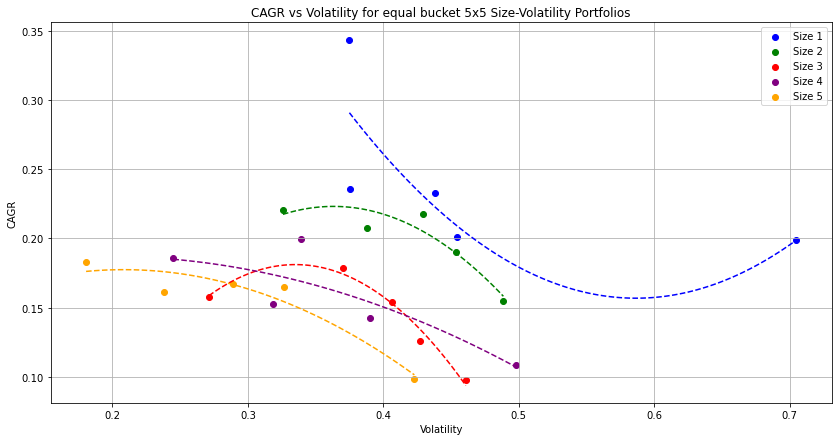

In [90]:
plt.figure(figsize=(14, 7))
colors = ["blue", "green", "red", "purple", "orange"]

for i in range(5):
    # Extract rows for the current size group
    size_group = cagr_vol_df.loc[cagr_vol_df.index.str.startswith(f"Size_{i+1}")]
    x = size_group["Volatility"]
    y = size_group["CAGR"]

    plt.scatter(x, y, label=f"Size {i+1}", color=colors[i])

    if len(x) > 1:  
        coeffs = np.polyfit(x, y, deg=2)
        poly_fit = np.poly1d(coeffs)
        x_fit = np.linspace(x.min(), x.max(), 100)
        plt.plot(x_fit, poly_fit(x_fit), color=colors[i], linestyle="--")

plt.xlabel("Volatility")
plt.ylabel("CAGR")
plt.title("CAGR vs Volatility for equal bucket 5x5 Size-Volatility Portfolios")
plt.legend()
plt.grid(True)
plt.show()


# 5x5 size-volatility portfolio analysis with Fama-French breakpoints

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# DataFrame to store returns for 5x5 Size-Volatility portfolios
size_vol_returns_df = pd.DataFrame(
    index=mcap.index, 
    columns=[f"Size_{i+1}-Vol_{j+1}" for i in range(5) for j in range(5)]
)

for quarter in mcap.index:
    # Extract the pool of stocks for the quarter from mcapmap
    pool_of_stocks = set(mcapmap.loc[quarter].dropna().explode())
    
    mcap_quarter = pd.to_numeric(mcap.loc[quarter], errors='coerce')
    
    # Filter valid stocks 
    valid_stocks = pool_of_stocks.intersection(mcap_quarter.dropna().index).intersection(
        volatility.loc[quarter].dropna().index)

    # get subsets of market cap and volatility data for valid stocks
    mcap_data = mcap_quarter.loc[valid_stocks]
    vol_data = volatility.loc[quarter, valid_stocks]

    # Sort stocks into 5 size groups based on the 3rd, 7th, 13th, and 25th percentiles
    size_breakpoints = mcap_data.quantile([0.03, 0.07, 0.13, 0.25]).values
    size_groups = {
        f"Size_{i+1}": mcap_data[(mcap_data > (size_breakpoints[i-1] if i > 0 else -float('inf'))) &
                                  (mcap_data <= (size_breakpoints[i] if i < 4 else float('inf')))].index.tolist()
        for i in range(5)
    }

    for size_group, size_stocks in size_groups.items():
        vol_subset = vol_data.loc[size_stocks].dropna()

        # Sort stocks into 5 equal-sized volatility groups within each size group
        vol_sorted_stocks = vol_subset.sort_values().index.tolist()
        vol_size = len(vol_sorted_stocks) // 5
        vol_groups = {
            f"{size_group}-Vol_{j+1}": vol_sorted_stocks[j * vol_size:(j + 1) * vol_size]
            for j in range(5)
        }

        # Calculate returns for each size-volatility portfolio
        if quarter != mcap.index[-1]:  
            next_quarter = mcap.index[mcap.index.get_loc(quarter) + 1]

            for vol_group, portfolio in vol_groups.items():
                if len(portfolio) > 0:
                    portfolio_return = calculate_ew_returns(
                        portfolio, price.loc[quarter], price.loc[next_quarter]
                    )
                    size_vol_returns_df.loc[quarter, vol_group] = portfolio_return
                else:
                    size_vol_returns_df.loc[quarter, vol_group] = 0

size_vol_returns_df = size_vol_returns_df.astype(float)

size_vol_returns_df

,Size_1-Vol_1,Size_1-Vol_2,Size_1-Vol_3,Size_1-Vol_4,Size_1-Vol_5,Size_2-Vol_1,Size_2-Vol_2,Size_2-Vol_3,Size_2-Vol_4,Size_2-Vol_5,...,Size_4-Vol_1,Size_4-Vol_2,Size_4-Vol_3,Size_4-Vol_4,Size_4-Vol_5,Size_5-Vol_1,Size_5-Vol_2,Size_5-Vol_3,Size_5-Vol_4,Size_5-Vol_5
quarter,,,,,,,,,,,,,,,,,,,,,
2005-01-01,0.999649,0.375617,0.356884,0.601699,0.779794,0.347233,0.290952,0.429607,0.345310,0.422505,...,0.389335,0.440607,0.377991,0.494097,0.395682,0.158089,0.234767,0.290784,0.241357,0.305003
2005-04-01,0.361452,0.192237,0.249970,0.492378,0.468348,0.378605,0.286126,0.177056,0.587305,0.288296,...,0.381216,0.302965,0.404237,0.633884,0.290669,0.151986,0.229939,0.246680,0.251088,0.422096
2005-07-01,0.141776,0.081807,-0.019505,-0.133086,-0.254362,-0.052977,-0.217318,-0.114706,-0.064105,-0.228881,...,-0.076267,0.011755,-0.128633,-0.120949,-0.232459,0.114073,0.077766,0.015724,-0.015207,-0.004191
2005-10-01,0.054767,0.021099,-0.033846,-0.083008,0.004998,-0.066911,-0.060216,-0.014489,-0.147100,0.024272,...,0.185638,0.112251,-0.038446,-0.095873,-0.011181,0.298229,0.111229,0.081122,0.056144,0.074713
2006-01-01,-0.047253,-0.188406,-0.108008,-0.145519,0.045894,0.019918,-0.090764,-0.061977,-0.086880,-0.150394,...,0.342149,-0.081714,-0.015607,-0.053891,-0.014665,-0.118248,-0.105937,-0.024433,-0.060057,-0.039581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,0.346317,0.400038,0.443508,0.255664,0.222919,0.192899,0.234033,0.180146,0.335661,0.332942,...,0.228782,0.270377,0.206576,0.256150,0.138800,0.123049,0.164494,0.206560,0.231096,0.259858
2023-04-01,0.146450,0.166793,0.182817,1.234556,0.356091,0.063048,0.417318,0.181639,0.155631,0.441372,...,0.168061,0.134440,0.181107,0.171243,0.226435,0.102358,0.148081,0.135189,0.191306,0.287916
2023-07-01,0.258146,0.220603,0.166264,0.109590,0.239069,0.115420,0.149221,0.140697,0.102576,0.012492,...,0.161215,0.128564,0.147035,0.071993,0.074092,0.102981,0.134482,0.145220,0.180242,0.199937


# Compute returns and volatility for fama-french 5x5 portfolios

In [92]:
# calculate annualized returns and volatility
def calculate_cagr(returns, periods_per_year=4):
    total_return = (1 + returns).prod()
    n_periods = len(returns)
    return total_return ** (periods_per_year / n_periods) - 1

def calculate_volatility(returns, periods_per_year=4):
    return returns.std() * (periods_per_year ** 0.5)

cagr_vol_df = pd.DataFrame(columns=["CAGR", "Volatility"], index=size_vol_returns_df.columns)

for portfolio in size_vol_returns_df.columns:
    returns = size_vol_returns_df[portfolio].dropna()
    cagr_vol_df.loc[portfolio, "CAGR"] = calculate_cagr(returns)
    cagr_vol_df.loc[portfolio, "Volatility"] = calculate_volatility(returns)

cagr_vol_df = cagr_vol_df.astype(float)

cagr_vol_df

,CAGR,Volatility
Size_1-Vol_1,0.565242,1.477220
Size_1-Vol_2,0.349797,0.421703
Size_1-Vol_3,0.357143,0.436717
Size_1-Vol_4,0.399224,0.663501
Size_1-Vol_5,0.545871,3.084958
Size_2-Vol_1,0.271699,0.329209
Size_2-Vol_2,0.122148,0.401263
Size_2-Vol_3,0.232246,0.445789
Size_2-Vol_4,0.236928,0.483796
Size_2-Vol_5,0.106834,0.542518


# Plot returns and volatility of Fama-French 5x5 portfolios

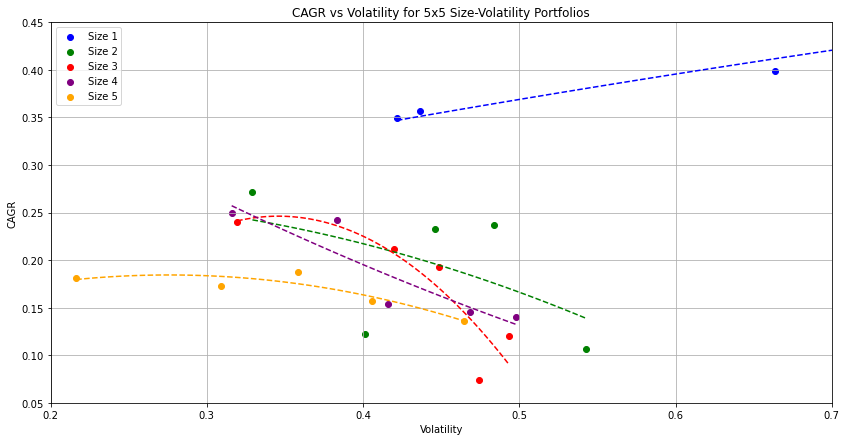

In [95]:
plt.figure(figsize=(14, 7))
colors = ["blue", "green", "red", "purple", "orange"]

for i in range(5):
    size_group = cagr_vol_df.loc[cagr_vol_df.index.str.startswith(f"Size_{i+1}")]
    x = size_group["Volatility"]
    y = size_group["CAGR"]

    plt.scatter(x, y, label=f"Size {i+1}", color=colors[i])

    if len(x) > 1: 
        coeffs = np.polyfit(x, y, deg=2)
        poly_fit = np.poly1d(coeffs)
        x_fit = np.linspace(x.min(), x.max(), 100)
        plt.plot(x_fit, poly_fit(x_fit), color=colors[i], linestyle="--")

plt.xlabel("Volatility")
plt.ylabel("CAGR")
plt.title("CAGR vs Volatility for 5x5 Size-Volatility Portfolios")
plt.legend()
plt.xlim(0.2,0.7)
plt.ylim(0.05,0.45)
plt.grid(True)
plt.show()
